# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
from utils.all_imports import *;
%matplotlib inline

None


In [2]:
# Some global script variables
# --------------------------------------------------------------------------- #
dataset_path, dataset_name, column_names, TARGET_COL = \
    get_dataset_location() # Info Data to be fetched
estimators_list, estimators_names = get_estimators() # Estimator to be trained

dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

# variables used for pass through arrays used to store results
pos_gs = 0; pos_cv = 0

# Array used for storing graphs
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))
pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = list(range(10, 1, -1))

In [3]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [4]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #
rescaledX, y, columns = prepare_data_for_train(dataset, target_col=TARGET_COL)

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64
shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [5]:
show_table_pc_analysis(X=rescaledX)

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [6]:
# Parameters to be tested for Cross-Validation Approach
# -----------------------------------------------------
param_grids = []
parmas_logreg = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    # 'random_state': (0,),
}; param_grids.append(parmas_logreg)

parmas_knn_clf = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
}; param_grids.append(parmas_knn_clf)

params_sgd_clf = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'class_weight': (None, 'balanced'),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6),
    # 'random_state': (0,),
}; param_grids.append(params_sgd_clf)

kernel_type = 'svm-rbf-kernel'
params_svm_clf = {
    # 'gamma': (1e-7, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3, 1e+5, 1e+7),
    'gamma': (1e-5, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3, 1e+5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    'degree': (1,2,4,8),
    'coef0': (.001, .01, .1, 0.0, 1.0, 10.0),
    'shrinking': (True, False),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'class_weight': (None, 'balanced'),
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,),
}; param_grids.append(params_svm_clf)

parmas_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'splitter': ('best', 'random',),
    'class_weight': (None, 'balanced'),
}; param_grids.append(parmas_tree)

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False),
    'min_samples_leaf': (1,2,3,4,5),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'class_weight': (None, 'balanced', 'balanced_subsample'),
}; param_grids.append(parmas_random_forest)

# Some variables to perform different tasks
# -----------------------------------------------------
N_CV, N_KERNEL, N_GS = 9, 5, 6;
nrows = N_KERNEL // 2 if N_KERNEL % 2 == 0 else N_KERNEL // 2 + 1;
ncols = 2; grid_size = [nrows, ncols]

| Learning Technique | Type of Learner | Type of Learning | Classification | Regression | Clustering |
| --- | --- | --- | --- | --- | --- |
| *Stochastic Gradient Descent (SGD)* | *Linear Model* | *Supervised Learning*| *Supported* | *Supported* | *Not-Supported*|

In [7]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Kernel PCA: Linear | SGD
              precision    recall  f1-score   support

     class 0       0.32      1.00      0.48         6
     class 1       1.00      0.54      0.70        28

    accuracy                           0.62        34
   macro avg       0.66      0.77      0.59        34
weighted avg       0.88      0.62      0.66        34

Best Score (CV-Train) Best Score (Test)   AUC  P-value
                 0.95              0.62  0.77  0.15842


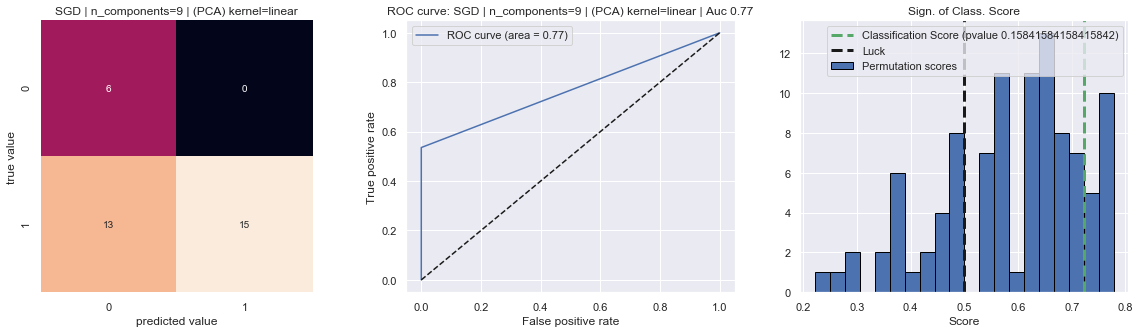

Kernel PCA: Poly | SGD
              precision    recall  f1-score   support

     class 0       0.40      0.67      0.50         6
     class 1       0.92      0.79      0.85        28

    accuracy                           0.76        34
   macro avg       0.66      0.73      0.67        34
weighted avg       0.83      0.76      0.79        34

Best Score (CV-Train) Best Score (Test)   AUC  P-value
                 0.92              0.76  0.73  0.00990


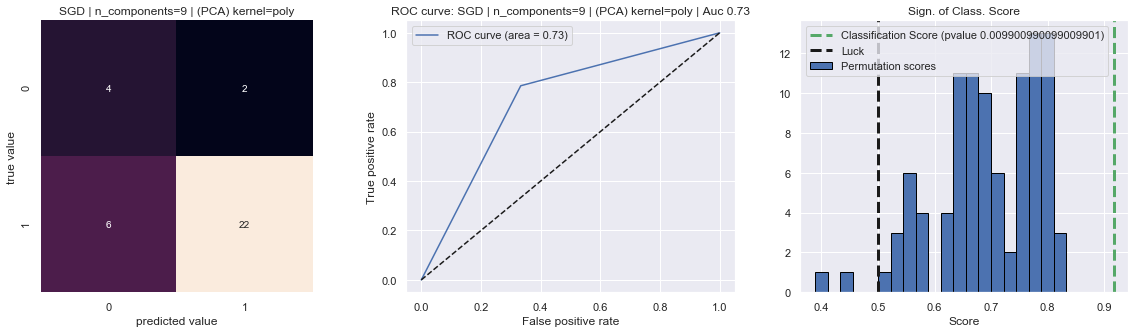

Kernel PCA: Rbf | SGD
              precision    recall  f1-score   support

     class 0       0.50      0.17      0.25         6
     class 1       0.84      0.96      0.90        28

    accuracy                           0.82        34
   macro avg       0.67      0.57      0.57        34
weighted avg       0.78      0.82      0.79        34

Best Score (CV-Train) Best Score (Test)   AUC  P-value
                 0.92              0.82  0.57  0.00990


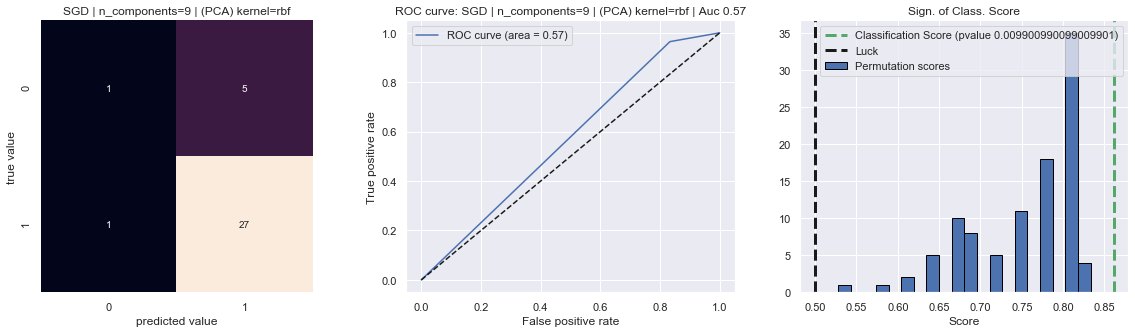

Kernel PCA: Cosine | SGD
              precision    recall  f1-score   support

     class 0       0.21      1.00      0.34         6
     class 1       1.00      0.18      0.30        28

    accuracy                           0.32        34
   macro avg       0.60      0.59      0.32        34
weighted avg       0.86      0.32      0.31        34

Best Score (CV-Train) Best Score (Test)   AUC  P-value
                 0.95              0.32  0.59  0.06931


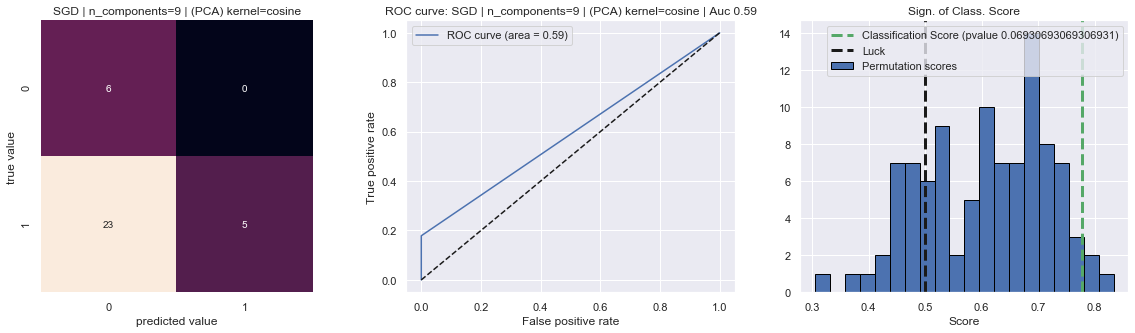

Kernel PCA: Sigmoid | SGD
              precision    recall  f1-score   support

     class 0       0.24      1.00      0.39         6
     class 1       1.00      0.32      0.49        28

    accuracy                           0.44        34
   macro avg       0.62      0.66      0.44        34
weighted avg       0.87      0.44      0.47        34

Best Score (CV-Train) Best Score (Test)   AUC  P-value
                 0.92              0.44  0.66  0.02970


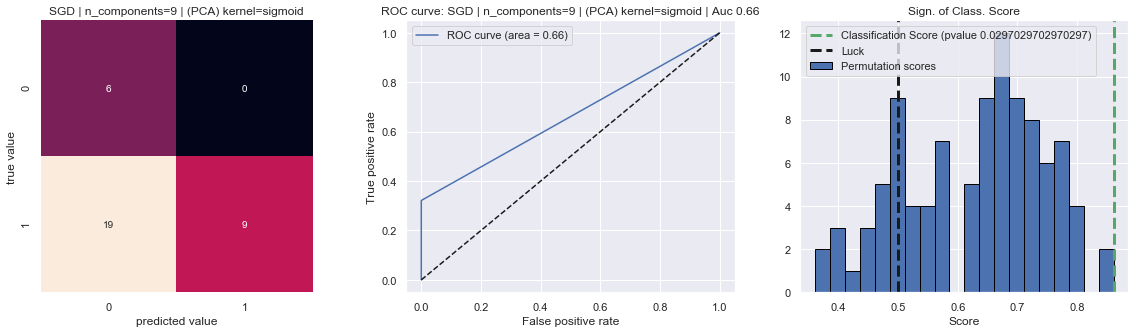

In [9]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX; pos = 3

df_gs, df_auc_gs, df_pvalue = grid_search_all_by_n_components(
    estimators_list=estimators_list[pos], \
    param_grids=param_grids[pos - 1],
    estimators_names=estimators_names[pos], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=False, verbose=1, plot_dest=plot_dest, debug_var=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *Sgd Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state generally speaking that looking at the weighted values of *Recall, Precision, and F1-Scores* we obtained good performance and and except for one trial where we got lower and worst results, when *Polynomial and Rbf Tricks* is selected, in the remaning cases have gotten remarkable results. More precisely we can say what follows:

- speaking about __Linear kernel Pca based Sgd Classifier__, when adoping the default threshold of *.5* for classification purposes we have a model that reaches an accuracy of *65%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *79%* with a Roc Curve that shows a behavior for which the model increases its *TPR* without affecting the *FPR* score, however at  a given point the Roc Curve trend turns so that the two cited scores begin to increase linearly and with a slope lower than that of Random Classifier so that FPR increases faster. The model is very precise when predicting class 1 instances but it has a recall of just *54%* so misclassified more or less half of samples from class 1 and this fact influenced instead the precision of class 0 that is a bit low, just *32%*, while class 0 recall is very high. Since the test accuracy score loses nearly 30 percent points we can assume that sucha model quite overfit to train data, we are not really encouraged to adopt it except we decied to exploit it for including it in an ensemble classifier, more boosting like than bagging one.

- observing __Polynomial kernel Pca based Sgd Estimator__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *76%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *73%*. It represents the best result obtained running th SGD based Training Algorithm upon our input dataset, in particular it obtained high precision and high recall for class 1, in other words such a model is able to recognize and correctly classify most of the data examples whose true label is indeed class 1. However, even if the model has high recall related to class 0, since the dataset is unbalanced we cannot say the same things for precision score about the class 0. So the model is somewhat uncertain when predicting class 0 as label  value for new observations.

- review __Rbf kernel Pca based Sgd Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *82%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *57%*. In particular such a trial along with the *PCosine kernel Pca based Sgd Classifier* are the two attempts that lead to worts results, since the model overfit against the data employed at training time, but also the model gained weights that tend to predict every thing as class 1 instance. So, the resulting scores tell us that the model is highly precise and obtained high recall related to class 1, convercely has very low performance for precision and recall referred to class 0. Since such a model is performing just a little bit better than random classifier, can be largely adopted along other similar models for building voting classifier, following boosting like classifier policy and behavior.

- looking at __Cosine kernel Pca based Sgd Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *32%* at test time against an accuracy of *95%* at train step, while the Auc score reaches a value of just *59%*.  Here the fine tuned model obtained from grid-search approach tells us that we are able to classify with high precision a few data examples from class 1, and even if we correctly classify all instances from class 0, we also wrongly predict class labels for most of instances,. whose true label is class 1. This means that the model is highly uncertain when predicting class 0 as the output target label. Moreover, the model's ROC Curve performs slighltly better than the random classifier, and we end up saying that such a model has gained weights and hyper-params that tend to predict the unknown instances as belonging to class 0 most of the time. We cannot neither say that switching the class labels between the two classes will allow us to obtain a better result since the roc curve trend is just a little bit better than the random classifier.

- finally, referring to __Sigmoid kernel Pca based Sgd Model__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *44%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *66%*. This model behaves more or less as the model obtained from the first trial performed for Sgd-based classifier, so as the first model is slightly worst than the best model found here when adopting as classifier Sgd technique, that is the *Cosine kernel Pca based Sgd Classifier*.

__Significance Analysis__: finally, when looking at the different graphics related to the test which aims at investigating the diagnostic power of our different models we have fine tuned for *SGD Classifier*, picking the best one for such a test we can notice that beacues of the *signficance level* $\alpha$ set equal to *0.05 that is 5% of chance to reject the Null-Hypothesis $H_{0}$*, we have obtained following results. Adopting the SGD statistical learning technique for classification fine tuned as above with hyper-params selectd also depending on the kind of *kernel-trick adopted for kernel-Pca unsupervised technique*, we can calim that only two out of five trials lead to a *p-vlaue* worst than *selected significance level equal to 5%*, which are *Linear- and Cosine-kernel Pca based Sgd Classifier*, so rejecting the *Null-Hypotesis* for those two cases will results into a *Type I Error*. While the remaining three cases, that are *Poly-, Rbf- and Sigmoid-kernel Pca based Sgd Classifier* have obtained a p-value over the range $[.9, 3]$ *in percet points*, so we are satisfyed for the results obtained in terms of significance scores, however, only *Poly-, and Rbf-kernel Pca based Sgd Classifier* really matter or are worth models since they do not overfit too much and do not go worstly as *Sigmoid-kernel Pca based Sgd Classifier* at test time.

#### Table Fine Tuned Hyper-Params(SGD Classifier)

In [10]:
# create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)
show_table_summary_grid_search(df_gs, df_auc_gs, df_pvalue)

,AUC(%),P-Value(%),Acc Train(%),Acc Test(%),alpha,class_weight,learning_rate,loss,max_iter,penalty,tol
SGD linear,0.77,15.84,0.95,0.62,0.1,balanced,optimal,modified_huber,50,l1,None
SGD poly,0.73,0.99,0.92,0.76,0.1,None,optimal,modified_huber,50,l2,None
SGD rbf,0.57,0.99,0.92,0.82,0.1,None,optimal,modified_huber,50,l2,None
SGD cosine,0.59,6.93,0.95,0.32,0.0001,balanced,optimal,modified_huber,50,l1,None
SGD sigmoid,0.66,2.97,0.92,0.44,0.001,balanced,optimal,modified_huber,50,l1,None


Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Rbfd Trick* or less overfit solution such as in the case of *Linear, Polynomial, Cosine, and Sigmoid Tricks*. Speaking about the hyper-parameters, we can say what follows:

- looking at __alpha hyper-parameter__, that is constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to *learning_rate* is set to *'optimal'*, as was here, we can notice that the final choice through the different trials was more or less tha same, meanning that the adopted kernel trick for performing kernel-Pca does not affected appreciably such a hyper-param, which three cases out of five was set to *0.1*, and the remaining case adopted *0.0001*, *0.001* for respectively Cosine and Sigmoid based *kernel-Pca*. This also remind us that while training the classifiers was not necessary to force a high regularization contribute for reducing the overfit as well as the learning process, even if we know that *Rbf kernel Pca based Sgd Classifier* overfits mostly against train data, and gained weights that encourages predicting all samples as belonging to class 1.

- reviewing __class_weight hyper-param__, what we can state about such a parameter is that it represents weights associated with classes. If not given, all classes are supposed to have weight one. The *“balanced” mode* uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as __n_samples / (n_classes * np.bincount(y))__. In particular we can notice that three out five models that were fine tuned accepted or selected *balanced weights*, which are *Linear-, Sigomoid-, Cosine-kernel Pca based Sgd Classifier*, while the remaining obtain better, when setting uniform weights which are models *Polynomial-, Rbf-kernel Pca based Sgd Classifier*. So the choiche of the right *kernel-trick* affected the subsequent selection at fine tuning time of the *class_weight hyper-param*. What we can further notice is that *Polynomial-, Rbf-kernel Pca based Sgd Classifier* more or less adopted same kind of values for hyper-params, as an instance for penalty hyper-param, however Polynomial model got worst performance in terms of accuracy but considering the other metrics simultaneously we can understand that the Poly model overfits less than Rbf one and so get better performance in general.

- speaking of __learning_rate hyper-param__, since we force this as the unique available choice it was just report for completeness.

- interesting it is the discussion about __loss parameter__, if fact we know that the possible options are *‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’*,  where the *‘log’ loss* gives logistic regression, a probabilistic classifier. *‘modified_huber’* is another smooth loss that brings tolerance to outliers as well as probability estimates. *‘squared_hinge’* is like hinge but is quadratically penalized. ‘perceptron’ is the linear loss used by the perceptron algorithm. Here, speaking about loss parameter we can clearly understand that the choice of a particular kernel trick does not affect the following choice of the loss function to be optimized, in fact uniformly all the models adopted or tend to prefer *modified_huber* loss function, allowing the models to fit to the data taking into account the fact that such a loss function is less sensitive to outliers, recalling inn fact that the Huber loss function is used in robust statistics, M-estimation and additive modelling. This loss is so cllaed beacues it derives from the plain version normally exploited for regression problems.

- also when referring to __max iteration parameter__, we can easily say that thte models evenly adopted somewhat small number of iteration before stopping the learning procedure, this might be also becaues we work with a small dataset and so a set of data points that is small tend to overfit quickly and this migth be the reason for which in order to avoid too much overfit the training procedure performed employing grid-search technique for fine-tuning tend to prefer tiny number of iterations set for training the model.

- __penalty parameter__, we recall here that it represents regularization term to be used. More precisely, defaults to *‘l2’* which is the standard regularizer for linear SVM models. *‘l1’* and *‘elasticnet’* might bring *sparsity* to the model (feature selection) not achievable with *‘l2’*. Also for such a hyper-param the choice of a particular *kernel-trick* to be used for *kernel-Pca* was affecting the subsequent selection of penalty contribute to regularize learning task, as was for *class weight hyper-param*. Here three over five models that are *Linear-, Sigomoid-, Cosine-kernel Pca based Sgd Classifier* adopted *l1-norm* as regularization term so the models's weights tend to be more sparse, while the remaining *Polynomial-, Rbf-kernel Pca based Sgd Classifier* models adopted *l2-nrom*. For the trials we have done, the models with *l1-regularization term* seem to get worst performance, more precisely *Sigomoid-, Cosine-kernel Pca based Sgd Classifier* even were worser than random classifier, while the *Linear-kernel Pca based Sgd Classifier* was slightly worst than Polynomial one, so does not overfit too much however we can say it can be exploited for ensemble method that follows a Boosting Policy.

If we imagine to build up an *Ensemble Classifier* from the family of *Average Methods*, which state that the underlying principle leading their creation requires to build separate and single classifiers than averaging their prediction in regression context or adopting a majority vote strategy for the classification context, we can claim that amongst the purposed *Sgd classifier*, for sure, we could employ the classifier found from all the trials, except for *Rbf, Cosine and Sigmoid kernel Pca based Sgd Classifiers*, since the first model is overly overfitting to the data used at train time and more precisely most of the time predicted correctly just samples from class 1 and misclassifyes instances from class 0, the others instead assumed the opposite behavior. Also, because of their performance metrics and also because Ensemble Methods such as Bagging Classifier, usually work fine exploiting an ensemble of independent and fine tuned classifier differently from Boosting Methods which instead are based on weak learners.

In [11]:
# show_histogram_first_sample(Xtrain_transformed, ytrain_, estimators_)

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

Extension that we can think of to better improve the analyses we can perform on such a relative tiny dataset many include, for preprocessing phases:
- Selecting different *Feature Extraction ant Dimensionality Reduction Techniques* other than Pca or kernel Pca such as: 
*linear discriminant analysis (LDA)*, or *canonical correlation analysis (CCA) techniques* as a pre-processing step.

Extension that we can think of to better improve the analyses we can perform on such a relative tiny dataset many include, for training phases:

- Selecting different *Ensemble Methods, investigating both Average based and Boosting based Statistical Learning Methods*.

Extension that we can think of to better improve the analyses we can perform on such a relative tiny dataset many include, for diagnostic analyses after having performed train and test phases:

- Using other measures, indicators and ghraphical plots such as the *Total Operating Characteristic (TOC)*, since also such a measure characterizes diagnostic ability while revealing more information than the ROC. In fact for each threshold, ROC reveals two ratios, TP/(TP + FN) and FP/(FP + TN). In other words, ROC reveals hits/(hits + misses) and false alarms/(false alarms + correct rejections). On the other hand, TOC shows the total information in the contingency table for each threshold. Lastly, the TOC method reveals all of the information that the ROC method provides, plus additional important information that ROC does not reveal, i.e. the size of every entry in the contingency table for each threshold.

## References section  <a class="anchor" id="references"></a>
### Main References
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Feature Extraction: PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    - (Linear Model: Logistic Regression) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    - (Neighbor-based Learning: Knn) https://scikit-learn.org/stable/modules/neighbors.html
    - (Stochastc Learning: SGD Classifier) https://scikit-learn.org/stable/modules/sgd.html#sgd
    - (Discriminative Model: SVM) https://scikit-learn.org/stable/modules/svm.html
    - (Non-Parametric Learning: Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (Ensemble, Non-Parametric Learning: RandomForest) https://scikit-learn.org/stable/modules/ensemble.html#forest
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- Statistics:
    - (Correlation and dependence) https://en.wikipedia.org/wiki/Correlation_and_dependence
    - (KDE) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Third Party Library:
    - (sklearn) https://scikit-learn.org/stable/index.html
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
        
### Others References
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Markdown Math part:
    - (Math Symbols Latex) https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols
    - (Tutorial 1) https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - (Tutorial 2) https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html